In [48]:
import warnings
warnings.filterwarnings('ignore')
import os,numpy as np,pandas as pd
from collections import OrderedDict
import seaborn as sns
from matplotlib import pyplot as plt

# MNE functions
import mne

from mne import Epochs,find_events
from mne.decoding import Vectorizer
from mne import create_info
from mne.io import RawArray
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit

from pyriemann.estimation import ERPCovariances, XdawnCovariances, Xdawn

from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM


In [49]:
df = pd.read_csv("/Users/aarooshbalakrishnan/Desktop/P300/venv/AAROOSH_test17INSANE.csv")
df.head

<bound method NDFrame.head of         1-31           CP3            C3             F5           PO3  \
0        0.0 -55262.355469 -90680.992188 -265571.562500   5589.455566   
1        1.0 -55457.218750 -90052.890625 -263598.906250   5483.709473   
2        3.0 -55375.343750 -97257.570312 -271477.093750   5630.694336   
3        4.0 -55236.339844 -92025.179688 -267075.531250   5614.735352   
4        5.0 -55387.214844 -89319.304688 -263295.625000   5500.875488   
...      ...           ...           ...            ...           ...   
146677  26.0 -34157.195312 -44536.472656 -131928.140625 -13326.958008   
146678  27.0 -34358.828125 -48141.359375 -134202.390625 -13283.640625   
146679  28.0 -34266.292969 -51446.445312 -137670.546875 -13253.464844   
146680  29.0 -34048.699219 -48406.429688 -135979.218750 -13297.520508   
146681  30.0 -34113.875000 -44489.933594 -132199.984375 -13328.633789   

                 PO4            F6            C4           CP4  Marker  
0      -30005.603516

In [50]:
df = df.drop(["1-31"], axis=1)
df.head()
df.columns = ["CP3", "C3", "F5", "PO3", "PO4", "F6", "C4", "CP4", "Marker"]


In [51]:
def df_to_raw(df):
    sfreq = 256  #our Neurosity headset sampling rate
    ch_names = list(df.columns)
    ch_types = ['eeg'] * (len(df.columns) - 1) + ['stim']
    ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')

    df = df.T 
    df[:-1] *= 1e-6  #convert from uVolts to Volts 

    info = create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq)

    raw = mne.io.RawArray(df, info)
    raw.set_montage(ten_twenty_montage)

    #plotting power spectral density
    raw.compute_psd().plot()

    return raw
raw = df_to_raw(df)

Creating RawArray with float64 data, n_channels=9, n_times=146682
    Range : 0 ... 146681 =      0.000 ...   572.973 secs
Ready.
Effective window size : 8.000 (s)


In [52]:
raw.filter(1,18, method='iir')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 18 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 18.00 Hz: -6.02, -6.02 dB



Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,11 points
Good channels,"8 EEG, 1 Stimulus"
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,256.00 Hz
Highpass,1.00 Hz
Lowpass,18.00 Hz


In [53]:
from mne import Epochs, find_events

def getEpochs(raw, event_id, tmin, tmax, picks):

    #epoching
    events = find_events(raw)
    epochs = Epochs(raw, events=events, event_id=event_id, 
                    tmin=tmin, tmax=tmax, baseline=None, preload=True,verbose=False, picks=picks)  #8 channels
    print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)

    return epochs

In [54]:
event_id = {'Non-Target': 1, 'Target' : 2} #changed nontarget from 1 to 0
tmin = -0.1 # tmin and tmax are changeable so we can always do that
tmax = 0.6 
eeg_channels = mne.pick_types(raw.info, eeg=True)
picks= eeg_channels
epochs = getEpochs(raw, event_id, tmin, tmax, picks)

721 events found on stim channel Marker
Event IDs: [1 2]
sample drop %:  0.0


In [55]:
print(len(epochs))


721


[1 1 1 2 1 1 2 1 1 1 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 2 1 1 1 2 2 1 1
 1 2 1 2 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1 2 1
 1 1 1 1 1 1 2 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1
 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1 2 1 1 1 2 1 2
 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 1 1 1 2 1 1 1 1 2 1 1 1 1 1 1 2 2
 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 2 1 1 1 1
 2 1 1 1 2 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 1 2 1 1 1 1 1
 1 2 1 1 1 2 1 1 1 1 1 1 1 1 1 1 2 1 2 1 1 2 2 1 1 2 2 1 1 1 1 1 1 1 2 1 1
 1 2 1 1 1 1 1 1 2 1 1 1 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 2 1 1 1 1
 1 1 1 1 2 2 1 1 1 1 1 1 1 1 2 1 1 2 1 1 2 1 2 1 2 1 1 1 1 2 2 2 1 2 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 2 1 2 1 1 1 1 1 1
 1 2 1 1 1 1 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 2 1 1
 1 1 1 1 2 1 1 1 1 1 1 2 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pyriemann/utils/mean.py:659: UserWarning: Convergence not reached
  warnings.warn("Convergence not reached")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pyriemann/utils/mean.py:659: UserWarning: Convergence not reached
  warnings.warn("Convergence not reached")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pyriemann/utils/mean.py:659: UserWarning: Convergence not reached
  warnings.warn("Convergence not reached")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pyriemann/utils/mean.py:659: UserWarning: Convergence not reached
  warnings.warn("Convergence not reached")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pyriemann/utils/mean.py:659: UserWarning: Convergence not reached
  warnings.warn("Convergence not reached")
/Library/Frameworks/Python.framework/Versions/3.11/lib/

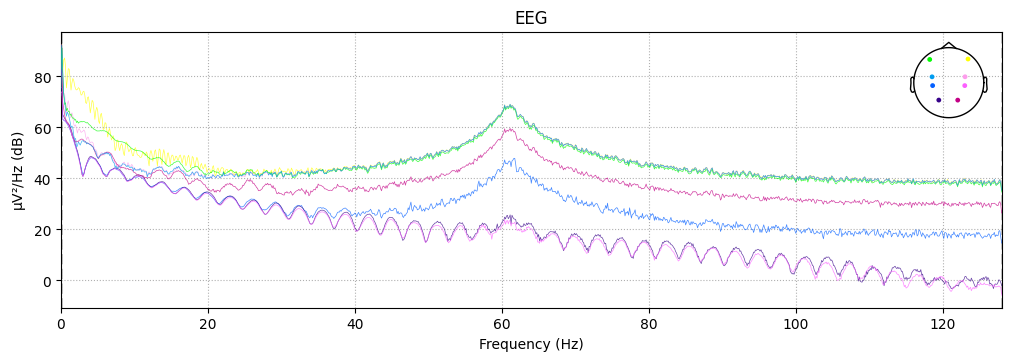

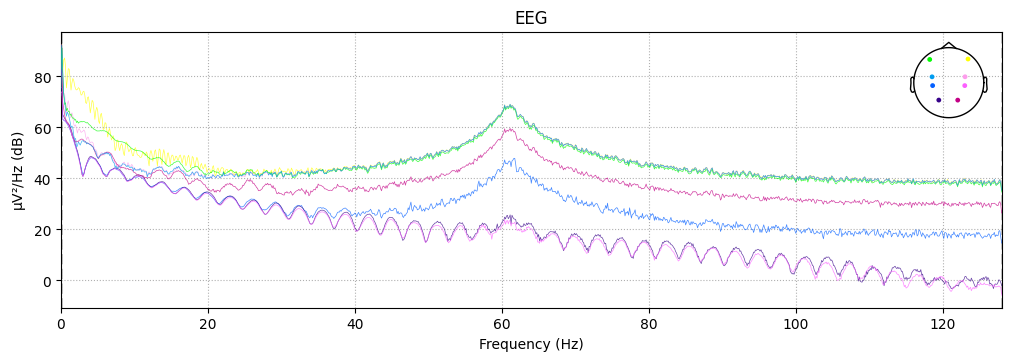

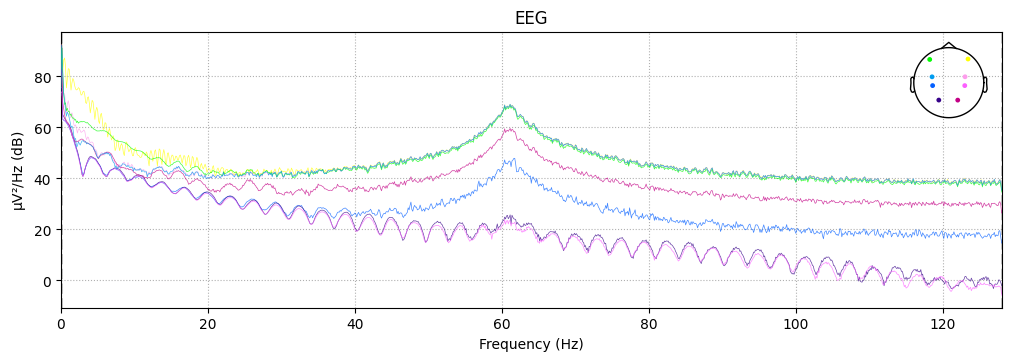

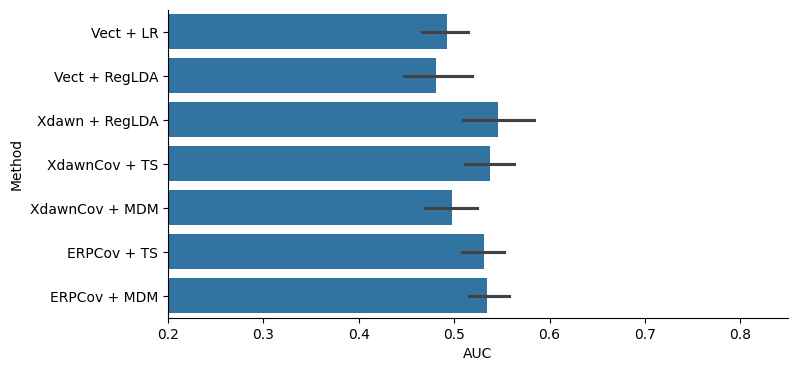

In [56]:
clfs = OrderedDict()
clfs['Vect + LR'] = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression())
clfs['Vect + RegLDA'] = make_pipeline(Vectorizer(), LDA(shrinkage='auto', solver='eigen'))
clfs['Xdawn + RegLDA'] = make_pipeline(Xdawn(2, classes=[1]), Vectorizer(), LDA(shrinkage='auto', solver='eigen'))

clfs['XdawnCov + TS'] = make_pipeline(XdawnCovariances(estimator='oas'), TangentSpace(), LogisticRegression())
clfs['XdawnCov + MDM'] = make_pipeline(XdawnCovariances(estimator='oas'), MDM())


clfs['ERPCov + TS'] = make_pipeline(ERPCovariances(), TangentSpace(), LogisticRegression())
clfs['ERPCov + MDM'] = make_pipeline(ERPCovariances(), MDM())
print(epochs.events[:, -1])

epochs.pick_types(eeg=True)
X = epochs.get_data() * 1e6
times = epochs.times
y = epochs.events[:, -1]

# define cross validation
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.25, random_state=42)

# run cross validation for each pipeline
auc = []
methods = []
for m in clfs:
    res = cross_val_score(clfs[m], X, y==2, scoring='roc_auc', cv=cv, n_jobs=-1)
    auc.extend(res)
    methods.extend([m]*len(res))

results = pd.DataFrame(data=auc, columns=['AUC'])
results['Method'] = methods

plt.figure(figsize=[8,4])
sns.barplot(data=results, x='AUC', y='Method')
plt.xlim(0.2, 0.85)
sns.despine()
plt.show()